In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pprint

import torch
import torch.backends
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from agents import Agent, attach_agents
from models import VGG16
from training_utils import validate, train

Hyperparameters

In [2]:
class Args:
    checkpoint = 'best.pth.tar'  # Pretrained VGG weights for CIFAR10.
    num_workers = 0
    batch_size = 256
    lr_agents = 0.01
    lr_model = 0.001
    epochs = 200 
    penalty = 4  # lambda
    init_weight = 6.9   # Agent's initial weight value.
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

args = Args()

Load CIFAR-10 dataset

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True,
                              transform=transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomCrop(32, padding=4),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor(),
                              ]))

val_data = datasets.CIFAR10('./data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                            ]))

train_loader = DataLoader(train_data,
                          batch_size=args.batch_size,
                          shuffle=True,
                          num_workers=args.num_workers)

val_loader = DataLoader(val_data,
                        batch_size=args.batch_size,
                        shuffle=True,
                        num_workers=args.num_workers)

Files already downloaded and verified
Files already downloaded and verified


Load pretrained VGG16 model

In [4]:
checkpoint = torch.load(args.checkpoint, map_location=args.device)
model = VGG16()
model.load_state_dict(checkpoint['state_dict'])
model.to(args.device)
model.eval();

model_orig = copy.deepcopy(model)  # Copy of the original model, just in case.

Print the baseline accuracy

In [5]:
val_acc = validate(model, val_loader, args.device)
print('Baseline accuracy: {}'.format(val_acc))

Val: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s, acc=0.919]

Baseline accuracy: 0.9194


Attach agents

In [6]:
modules_to_prune = [['features.0', 'features.1'],
                    ['features.3', 'features.4'],
                    ['features.7', 'features.8'],
                    ['features.10', 'features.11'],
                    ['features.14', 'features.15'],
                    ['features.17', 'features.18'],
                    ['features.20', 'features.21'],
                    ['features.24', 'features.25'],
                    ['features.27', 'features.28'],
                    ['features.30', 'features.31'],
                    ['features.34', 'features.35'],
                    ['features.37', 'features.38'],
                    ['features.40', 'features.41'],
                    ['classifier.0', 'classifier.1']]

agents, name_to_agent, num_agents, num_subagents = attach_agents(model,
                                                                 modules_to_prune,
                                                                 args.device,
                                                                 args.init_weight)

In [7]:
print('Total agents: {}'.format(sum(agent.num_subagents for agent in agents)))
assert num_subagents == sum(agent.num_subagents for agent in agents)

Total agents: 4736


Training the model

In [8]:
optimizer_agents = optim.Adam([agent.w for agent in agents], lr=args.lr_agents)
# scheduler_agents = StepLR(optimizer_agents, step_size=5, gamma=0.3)

optimizer_model = optim.Adam(model.parameters(), lr=args.lr_model)#, momentum=0.9, weight_decay=0.0005)
# scheduler_model = StepLR(optimizer_model, step_size=5, gamma=0.3)

criterion_model = nn.CrossEntropyLoss().to(args.device)
for epoch in range(args.epochs):
    print('Epoch: {}'.format(epoch))
    
    train_logs = train(model, agents, train_loader, optimizer_model,
                       optimizer_agents, criterion_model, args.penalty,
                       args.device, optimize_agents=True, optimize_model=False)
    
    [agent.eval() for agent in agents]
    val_acc = validate(model, val_loader, args.device)
    
pprint.pprint(train_logs)
print('Val accuracy: {}'.format(val_acc))

Val: 100%|██████████| 40/40 [00:02<00:00, 17.07it/s, acc=0.832]


Epoch: 177


Val: 100%|██████████| 40/40 [00:02<00:00, 17.09it/s, acc=0.831]


Epoch: 178


Val: 100%|██████████| 40/40 [00:02<00:00, 17.31it/s, acc=0.837]


Epoch: 179


Val: 100%|██████████| 40/40 [00:02<00:00, 17.26it/s, acc=0.831]


Epoch: 180


Val: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, acc=0.834]


Epoch: 181


Val: 100%|██████████| 40/40 [00:02<00:00, 17.06it/s, acc=0.835]


Epoch: 182


Val: 100%|██████████| 40/40 [00:02<00:00, 17.24it/s, acc=0.834]


Epoch: 183


Val: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, acc=0.837]


Epoch: 184


Val: 100%|██████████| 40/40 [00:02<00:00, 17.27it/s, acc=0.842]


Epoch: 185


Val: 100%|██████████| 40/40 [00:02<00:00, 16.54it/s, acc=0.835]


Epoch: 186


Val: 100%|██████████| 40/40 [00:02<00:00, 17.11it/s, acc=0.835]


Epoch: 187


Val: 100%|██████████| 40/40 [00:02<00:00, 17.31it/s, acc=0.842]


Epoch: 188


Val: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, acc=0.842]


Epoch: 189


Val: 100%|██████████| 40/40 [00:02<00:00, 17.23it/s, acc=0.848]


Epoch: 190


Val: 100%|██████████| 40/40 [00:02<00:00, 17.09it/s, acc=0.842]


Epoch: 191


Val: 100%|██████████| 40/40 [00:02<00:00, 17.09it/s, acc=0.838]


Epoch: 192


Val: 100%|██████████| 40/40 [00:02<00:00, 17.24it/s, acc=0.838]


Epoch: 193


Val: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, acc=0.837]


Epoch: 194


Val: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, acc=0.836]


Epoch: 195


Val: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, acc=0.838]


Epoch: 196


Val: 100%|██████████| 40/40 [00:02<00:00, 16.67it/s, acc=0.838]


Epoch: 197


Val: 100%|██████████| 40/40 [00:02<00:00, 17.25it/s, acc=0.835]


Epoch: 198


Val: 100%|██████████| 40/40 [00:02<00:00, 16.95it/s, acc=0.834]


Epoch: 199


Val: 100%|██████████| 40/40 [00:02<00:00, 17.26it/s, acc=0.833]

{'accuracy': 0.8285,
 'accuracy_reward_avg': 0.1425,
 'compression_reward_avg': 119.40092,
 'full_reward_avg': 16.97522,
 'loss_agents_avg': 0.08436963385105133,
 'loss_model_avg': 0.0028895122361183166,
 'num_channels_dropped': 809.5875,
 'p_max': 0.9999898672103882,
 'p_min': 0.00030013261130079627,
 'probabilities_avg': 0.8230836944920675,
 'total_channels': 4736,
 'total_samples': 50000,
 'weights_avg': 3.604158333369664}
Val accuracy: 0.8334


In [9]:
p_list = []
for agent in agents:
    p_list += torch.sigmoid(agent.w).tolist()    

print('Avg p: {}'.format(sum(p_list)/len(p_list)))
print('Min p: {}'.format(min(p_list)))
print('Max p: {}'.format(max(p_list)))
print('Total agents: {}'.format(sum(agent.num_subagents for agent in agents)))
print('Agents p >= 0.5: {}'.format(sum(p >= 0.5 for p in p_list)))
print('Agents p >= 0.9: {}'.format(sum(p >= 0.9 for p in p_list)))
print('Agents p >= 0.998: {}'.format(sum(p >= 0.998 for p in p_list)))
print('Agents p >= 0.999: {}'.format(sum(p >= 0.999 for p in p_list)))

assert len(p_list) == sum(agent.num_subagents for agent in agents)

Avg p: 0.8296278080901716
Min p: 0.0002983564045280218
Max p: 0.9999898672103882
Total agents: 4736
Agents p >= 0.5: 4025
Agents p >= 0.9: 3376
Agents p >= 0.998: 824
Agents p >= 0.999: 507


Drop the highest weight channel.

In [10]:
p_list = []
for agent in agents:
    p_list += torch.sigmoid(agent.w).tolist()
p_list.sort(reverse=True)

thresh = p_list[1]
assert sum(p > thresh for p in p_list) == 1

for agent in agents:
    agent.eval(prob_threshold=thresh, threshold_type='BINARY_INV')
val_acc = validate(model, val_loader, args.device)

# Original accuracy
for agent in agents:
    agent.eval(prob_threshold=0.0, threshold_type='BINARY')
val_acc_orig = validate(model, val_loader, args.device)

print('Val acc: {}'.format(val_acc))
print('Val acc orig: {}'.format(val_acc_orig))
print('Accuracy drop: {}'.format(val_acc_orig - val_acc))

Val: 100%|██████████| 40/40 [00:02<00:00, 17.32it/s, acc=0.919]

Val acc: 0.9128
Val acc orig: 0.9194
Accuracy drop: 0.00660000000000005


Drop the lowest weight channel.

In [11]:
p_list = []
for agent in agents:
    p_list += torch.sigmoid(agent.w).tolist()
p_list.sort(reverse=False)

thresh = p_list[1]
assert sum(p < thresh for p in p_list) == 1

for agent in agents:
    agent.eval(prob_threshold=thresh, threshold_type='BINARY')
val_acc = validate(model, val_loader, args.device)

# Original accuracy
for agent in agents:
    agent.eval(prob_threshold=0.0, threshold_type='BINARY')
val_acc_orig = validate(model, val_loader, args.device)

print('Val acc: {}'.format(val_acc))
print('Val acc orig: {}'.format(val_acc_orig))
print('Accuracy drop: {}'.format(val_acc_orig - val_acc))

Val: 100%|██████████| 40/40 [00:02<00:00, 17.08it/s, acc=0.919]

Val acc: 0.9171
Val acc orig: 0.9194
Accuracy drop: 0.0022999999999999687


In [12]:
acc_high_list = []
acc_low_list = []
num_channels_list = [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250, 300]
p_list = []
for agent in agents:
    p_list += torch.sigmoid(agent.w).tolist()


# Highest weight channels
p_list.sort(reverse=True)
for x in num_channels_list:
    thresh = p_list[x]
    assert sum(p > thresh for p in p_list) == x

    for agent in agents:
        agent.eval(prob_threshold=thresh, threshold_type='BINARY_INV')
    val_acc = validate(model, val_loader, args.device)
    acc_high_list.append(val_acc*100)


# Lowest weight channels
p_list.sort(reverse=False)
for x in num_channels_list:
    thresh = p_list[x]
    assert sum(p < thresh for p in p_list) == x

    for agent in agents:
        agent.eval(prob_threshold=thresh, threshold_type='BINARY')
    val_acc = validate(model, val_loader, args.device)
    acc_low_list.append(val_acc*100)

Val: 100%|██████████| 40/40 [00:02<00:00, 16.51it/s, acc=0.838]


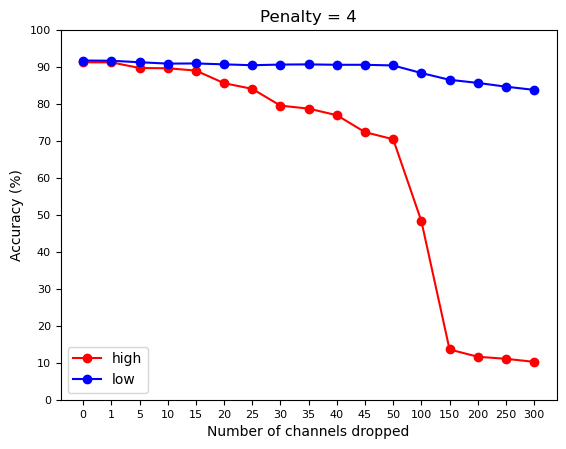

In [13]:
x_axis = [str(x) for x in num_channels_list]
plt.plot(x_axis, acc_high_list, label ='high', marker='o', color='red')
plt.plot(x_axis, acc_low_list, label ='low', marker='o', color='blue')

plt.xlabel("Number of channels dropped")
plt.ylabel("Accuracy (%)")
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=8)
plt.xticks(fontsize=8)
plt.legend()
plt.title("Penalty = {}".format(args.penalty))
plt.savefig('investigate_policies.png', bbox_inches='tight')
plt.show()